A importação das bibliotecas juntamente com o conjunto de dados utilizado foi realizado da seguinte maneira:

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import statsmodels.api as sm


from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

O conjunto de dados analisado foi encontrado através do repositório "COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University". A exibição dos dados que o Google utiliza também é baseada no mesmo dataset:

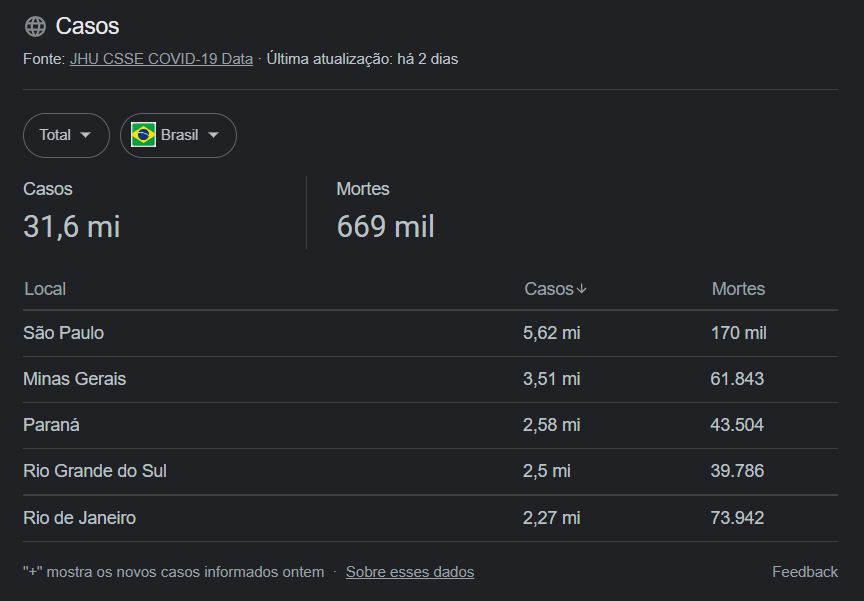

Dentro do repositório acima, podemos ver que a obtenção dos dados relacionados ao Brasil é realizada por Wesley Cota da Universidade federal de viçosa. O repositório dele pode ser encontrado a partir de : https://github.com/wcota/covid19br

In [ ]:
!wget https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv
!wget https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bcim/versao2016/geopackage/bcim_2016_21_11_2018.gpkg 
!wget https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/LEITOS/2022-06-16/esus-vepi.LeitoOcupacao_2021.csv
!wget https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/LEITOS/2022-06-18/esus-vepi.LeitoOcupacao_2022.csv 
!wget https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/LEITOS/2022-06-18/esus-vepi.LeitoOcupacao_2020.csv

--2022-07-26 23:52:08--  https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3824972 (3.6M) [text/plain]
Saving to: ‘cases-brazil-states.csv.1’

cases-brazil-states 100%[===================>]   3.65M  --.-KB/s    in 0.1s    

2022-07-26 23:52:09 (30.0 MB/s) - ‘cases-brazil-states.csv.1’ saved [3824972/3824972]

--2022-07-26 23:52:09--  https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bcim/versao2016/geopackage/bcim_2016_21_11_2018.gpkg
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 372666368 (355M)


Podemos ver todas as colunas da base de dados a seguir:

---



# Carregamento da base dos leitos

In [ ]:
leitos_file1 = pd.read_csv('./esus-vepi.LeitoOcupacao_2020.csv')  
leitos_file2 = pd.read_csv('./esus-vepi.LeitoOcupacao_2021.csv') 
leitos_file3 = pd.read_csv('./esus-vepi.LeitoOcupacao_2022.csv')  
leitos_file = pd.concat([leitos_file1, leitos_file2, leitos_file3])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
to_drop = ['Unnamed: 0','cnes','_p_usuario','_created_at','_updated_at','origem','excluido','validado','estado','municipio']
leitos_file.drop(to_drop, inplace=True, axis=1) 
newDF = leitos_file.dropna() 
newDF.sort_values(['estadoNotificacao'])   

first_column = newDF.pop('estadoNotificacao')
second_column = newDF.pop('municipioNotificacao') 

  
newDF.insert(0, 'estadoNotificacao', first_column) 
newDF.insert(1, 'municipioNotificacao', first_column)

newDfTotal = newDF    

newDfTotal['totalOcupacaoSuspeita'] = newDfTotal['ocupacaoSuspeitoCli'] + newDfTotal['ocupacaoSuspeitoUti']
newDfTotal['totalOcupacaoConfirmados'] = newDfTotal['ocupacaoConfirmadoCli'] + newDfTotal['ocupacaoConfirmadoUti']
newDfTotal['totalOcupacaoCovid'] = newDfTotal['ocupacaoCovidCli'] + newDfTotal['ocupacaoCovidUti']
newDfTotal['totalOcupacaoHospitalar'] = newDfTotal['ocupacaoHospitalarUti'] + newDfTotal['ocupacaoHospitalarCli']


excluded_columns = ['ocupacaoSuspeitoCli', 'ocupacaoSuspeitoUti','ocupacaoConfirmadoCli','ocupacaoConfirmadoUti','ocupacaoCovidCli','ocupacaoCovidUti','ocupacaoHospitalarUti','ocupacaoHospitalarCli' ]

for i in excluded_columns: 
  newDfTotal.pop(i)  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
data = pd.read_csv('./cases-brazil-states.csv',nrows = 0, sep=',')
data 

,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,...,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants


In [ ]:
data.columns.values

array(['epi_week', 'date', 'country', 'state', 'city', 'newDeaths',
       'deaths', 'newCases', 'totalCases', 'deathsMS', 'totalCasesMS',
       'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants',
       'deaths_by_totalCases', 'recovered', 'suspects', 'tests',
       'tests_per_100k_inhabitants', 'vaccinated',
       'vaccinated_per_100_inhabitants', 'vaccinated_second',
       'vaccinated_second_per_100_inhabitants', 'vaccinated_single',
       'vaccinated_single_per_100_inhabitants', 'vaccinated_third',
       'vaccinated_third_per_100_inhabitants'], dtype=object)

Podemos selecionar quais colunas queremos analisar:

In [ ]:
cols = ['epi_week', 'date', 'country', 'state', 'city', 'newDeaths',
       'deaths', 'newCases', 'totalCases', 'deathsMS', 'totalCasesMS',
       'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants',
       'deaths_by_totalCases', 'recovered', 'suspects', 'tests',
       'tests_per_100k_inhabitants', 'vaccinated',
       'vaccinated_per_100_inhabitants', 'vaccinated_second',
       'vaccinated_second_per_100_inhabitants', 'vaccinated_single',
       'vaccinated_single_per_100_inhabitants', 'vaccinated_third',
       'vaccinated_third_per_100_inhabitants']

In [ ]:
cols = ['suspects','date','state','totalCases','vaccinated', 'vaccinated_per_100_inhabitants', 'vaccinated_second',
       'vaccinated_second_per_100_inhabitants', 'vaccinated_single',
       'vaccinated_single_per_100_inhabitants', 'vaccinated_third',
       'vaccinated_third_per_100_inhabitants','totalCases_per_100k_inhabitants','deaths','recovered']

In [ ]:
data = pd.read_csv('./cases-brazil-states.csv', usecols = ['state'], sep=',') 
data

,state
0,SP
1,TOTAL
2,SP
3,TOTAL
4,SP
...,...
24257,SC
24258,SE
24259,SP
24260,TO


In [ ]:
data = pd.read_csv('./cases-brazil-states.csv',usecols = cols, sep=',')
data

,date,state,deaths,totalCases,totalCases_per_100k_inhabitants,recovered,suspects,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
0,2020-02-25,SP,0,1,0.00218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25,TOTAL,0,1,0.00047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26,SP,0,1,0.00218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-26,TOTAL,0,1,0.00047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-27,SP,0,1,0.00218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,2022-07-26,SC,22186,1831364,25560.61673,1607144.0,268966.0,6237943.0,87.06389,5701737.0,79.57998,277356.0,3.87110,3492383.0,48.74370
24258,2022-07-26,SE,6406,339776,14781.24989,313577.0,445.0,1973592.0,85.85703,1809561.0,78.72120,42047.0,1.82917,1212521.0,52.74821
24259,2022-07-26,SP,172555,5883611,12813.00708,4850000.0,876238.0,42403685.0,92.34443,39868792.0,86.82408,1276415.0,2.77971,33095195.0,72.07291
24260,2022-07-26,TO,4182,337036,21428.14455,281464.0,359.0,1157012.0,73.56075,992190.0,63.08166,54944.0,3.49324,474217.0,30.14987


É possível observar um ruído nos dados anteriores, há a ocorrência de diversas linhas com o Estado de "TOTAL", que representa  o total de casos por dia, podemos retirá-las para conseguir identificar apenas os estados que possuem casos registrados por dia

In [ ]:
data = pd.read_csv('./cases-brazil-states.csv',usecols = cols, sep=',')
filtro = data['state'] != 'TOTAL'
dataFiltred = data[filtro]
dataFiltred

,date,state,deaths,totalCases,totalCases_per_100k_inhabitants,recovered,suspects,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
0,2020-02-25,SP,0,1,0.00218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26,SP,0,1,0.00218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-27,SP,0,1,0.00218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-02-28,SP,0,2,0.00436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-02-29,SP,0,2,0.00436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24256,2022-07-26,RS,40373,2624124,23064.68204,2146461.0,10647.0,9722787.0,85.45823,9204078.0,80.89905,330054.0,2.90100,7045038.0,61.92221
24257,2022-07-26,SC,22186,1831364,25560.61673,1607144.0,268966.0,6237943.0,87.06389,5701737.0,79.57998,277356.0,3.87110,3492383.0,48.74370
24258,2022-07-26,SE,6406,339776,14781.24989,313577.0,445.0,1973592.0,85.85703,1809561.0,78.72120,42047.0,1.82917,1212521.0,52.74821
24259,2022-07-26,SP,172555,5883611,12813.00708,4850000.0,876238.0,42403685.0,92.34443,39868792.0,86.82408,1276415.0,2.77971,33095195.0,72.07291


Conseguimos identificar o tipo de cada campo

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24262 entries, 0 to 24261
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date                                   24262 non-null  object 
 1   state                                  24262 non-null  object 
 2   deaths                                 24262 non-null  int64  
 3   totalCases                             24262 non-null  int64  
 4   totalCases_per_100k_inhabitants        24262 non-null  float64
 5   recovered                              23619 non-null  float64
 6   suspects                               23668 non-null  float64
 7   vaccinated                             15531 non-null  float64
 8   vaccinated_per_100_inhabitants         15531 non-null  float64
 9   vaccinated_second                      14851 non-null  float64
 10  vaccinated_second_per_100_inhabitants  14851 non-null  float64
 11  va

In [ ]:
data.dtypes

date                                      object
state                                     object
deaths                                     int64
totalCases                                 int64
totalCases_per_100k_inhabitants          float64
recovered                                float64
suspects                                 float64
vaccinated                               float64
vaccinated_per_100_inhabitants           float64
vaccinated_second                        float64
vaccinated_second_per_100_inhabitants    float64
vaccinated_single                        float64
vaccinated_single_per_100_inhabitants    float64
vaccinated_third                         float64
vaccinated_third_per_100_inhabitants     float64
dtype: object

Conseguimos identificar todos os valores não preenchidos nas colunas

In [ ]:
data.isna().sum()

date                                         0
state                                        0
deaths                                       0
totalCases                                   0
totalCases_per_100k_inhabitants              0
recovered                                  643
suspects                                   594
vaccinated                                8731
vaccinated_per_100_inhabitants            8731
vaccinated_second                         9411
vaccinated_second_per_100_inhabitants     9411
vaccinated_single                        13310
vaccinated_single_per_100_inhabitants    13310
vaccinated_third                         15570
vaccinated_third_per_100_inhabitants     15570
dtype: int64

In [ ]:
data.describe()

,deaths,totalCases,totalCases_per_100k_inhabitants,recovered,suspects,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
count,24262.000000,2.426200e+04,24262.000000,2.361900e+04,2.366800e+04,1.553100e+04,15531.000000,1.485100e+04,14851.000000,1.095200e+04,10952.000000,8.692000e+03,8692.000000
mean,27383.585277,1.086209e+06,8387.713451,9.966834e+05,3.906211e+05,8.400523e+06,53.201515,6.639838e+06,40.843451,3.452184e+05,2.286551,4.020153e+06,22.150028
std,85959.155693,3.475904e+06,6510.237500,3.147668e+06,1.319134e+06,2.517059e+07,29.958999,2.108785e+07,28.176055,9.022264e+05,1.412679,1.298391e+07,17.183126
min,0.000000,1.000000e+00,0.000470,1.000000e+00,1.000000e+00,2.000000e+00,0.000010,1.000000e+00,0.000000,3.500000e+01,0.000080,1.000000e+00,0.000000
25%,2113.000000,1.083678e+05,2844.641740,1.042930e+05,1.381000e+03,6.303485e+05,22.131810,3.977200e+05,11.130865,5.050300e+04,1.690460,2.007720e+05,6.226313
50%,7054.500000,3.046605e+05,7562.239585,2.814640e+05,1.143500e+04,2.438553e+06,66.268050,1.763386e+06,46.002280,1.140330e+05,1.963175,9.365190e+05,20.284315
75%,17092.750000,7.062682e+05,12873.751930,6.541550e+05,1.484510e+05,5.874136e+06,78.039700,4.588494e+06,67.065080,2.617970e+05,2.503700,2.145560e+06,36.147712
max,677143.000000,3.362196e+07,29751.757430,2.738142e+07,8.866327e+06,1.799016e+08,96.646030,1.648615e+08,86.824080,5.347013e+06,9.298280,1.153862e+08,72.072910


In [ ]:
data['state'].value_counts()

SP       883
TOTAL    883
RJ       874
BA       873
ES       873
DF       872
AL       871
MG       871
RS       869
GO       867
PE       867
PR       867
RN       867
SC       867
AM       866
MS       865
SE       865
CE       863
AC       862
PA       861
PB       861
TO       861
PI       860
AP       859
MA       859
MT       859
RO       859
RR       858
Name: state, dtype: int64

In [ ]:
data['year'] = pd.DatetimeIndex(data['date']).year

Podemos fitrar os numeros totais de casos ocorrido dentro de um período específico. Como por exemplo:

In [ ]:
data_groupby = data.groupby('year')['totalCases'].sum()
data_groupby

year
2020     1784457032
2021    12414999752
2022    12154140888
Name: totalCases, dtype: int64

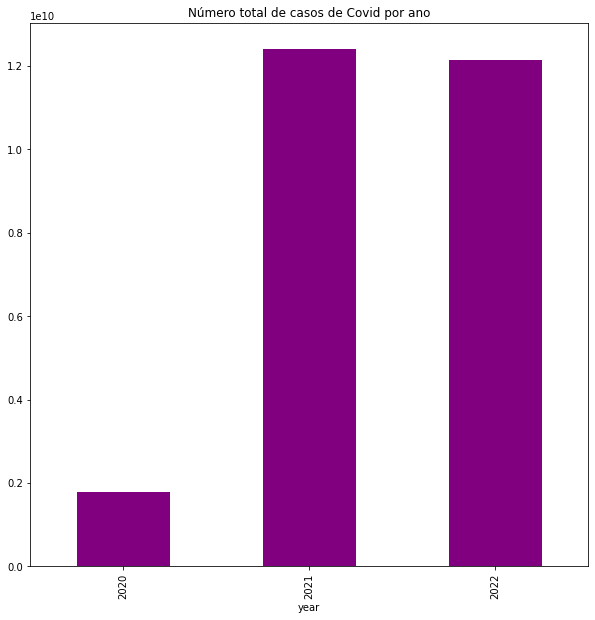

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Número total de casos de Covid por ano")
data_groupby.plot(kind='bar', x='date', y='totalCases', color='purple', label = 'totalCases')

## Relação entre vacinação e Estados

### Eliminando ruídos do dataset

In [ ]:
data_without_nan_values = data.dropna()
data_without_nan_values

,date,state,deaths,totalCases,totalCases_per_100k_inhabitants,recovered,suspects,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants,year
15089,2021-09-02,MS,9403,369475,13295.31707,354985.0,1381.0,1836215.0,66.07500,1053662.0,37.91534,234861.0,8.45132,282.0,0.01015,2021
15105,2021-09-02,TOTAL,582003,20834790,9767.02635,19138604.0,7958935.0,133236457.0,62.45918,60244403.0,28.24164,4661248.0,2.18512,282.0,0.00013,2021
15117,2021-09-03,MS,9411,369733,13304.60103,357475.0,1381.0,1839113.0,66.17928,1067906.0,38.42790,234861.0,8.45132,373.0,0.01342,2021
15133,2021-09-03,TOTAL,582743,20858394,9778.09153,19243454.0,7958935.0,133983801.0,62.80953,61424341.0,28.79478,4669260.0,2.18888,373.0,0.00017,2021
15145,2021-09-04,MS,9418,369916,13311.18617,357475.0,1381.0,1844651.0,66.37856,1075969.0,38.71804,234871.0,8.45168,537.0,0.01932,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,2022-07-26,SC,22186,1831364,25560.61673,1607144.0,268966.0,6237943.0,87.06389,5701737.0,79.57998,277356.0,3.87110,3492383.0,48.74370,2022
24258,2022-07-26,SE,6406,339776,14781.24989,313577.0,445.0,1973592.0,85.85703,1809561.0,78.72120,42047.0,1.82917,1212521.0,52.74821,2022
24259,2022-07-26,SP,172555,5883611,12813.00708,4850000.0,876238.0,42403685.0,92.34443,39868792.0,86.82408,1276415.0,2.77971,33095195.0,72.07291,2022
24260,2022-07-26,TO,4182,337036,21428.14455,281464.0,359.0,1157012.0,73.56075,992190.0,63.08166,54944.0,3.49324,474217.0,30.14987,2022


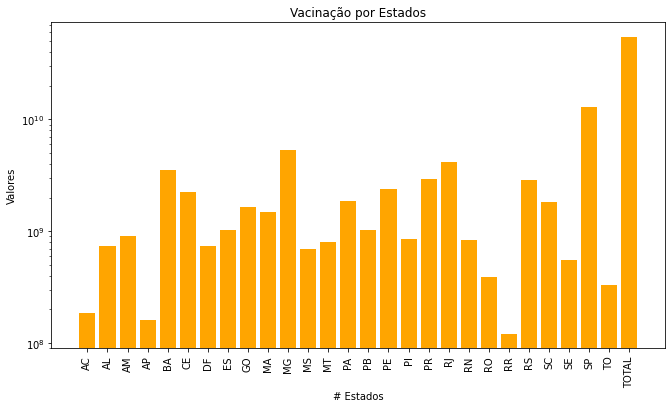

In [ ]:
vaccinated_per_state = data_without_nan_values.groupby('state')['vaccinated'].sum()

plt.figure(figsize =(11, 6))
plt.bar(vaccinated_per_state.index, vaccinated_per_state.values, color = 'orange')
plt.ylabel("Valores")
plt.xlabel("# Estados")
plt.title("Vacinação por Estados")
plt.xticks(rotation='vertical')
plt.yscale('log')
plt.show()


## Analise de vacinação no estado de Minas Gerais

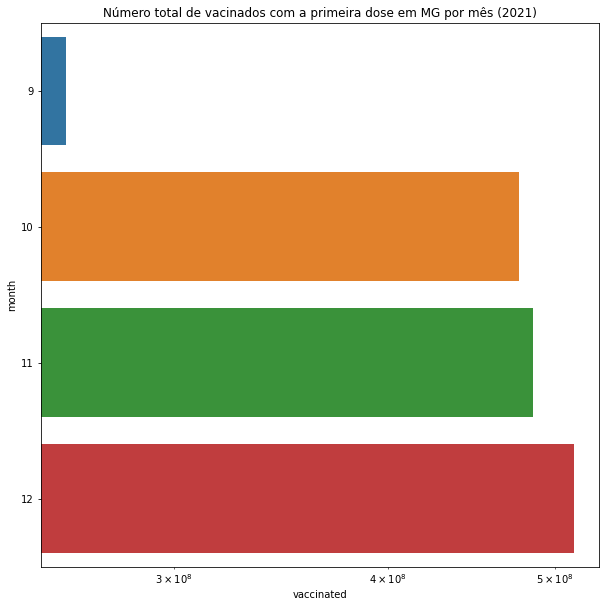

In [ ]:
def total_vaccinated_per_year_by_state(state,year):
    data_with_month_column = data_without_nan_values.assign(month = pd.DatetimeIndex(data_without_nan_values['date']).month)
    total_vaccinated_per_month_in_mg = data_with_month_column[data_with_month_column['state'] == state]
    return total_vaccinated_per_month_in_mg[total_vaccinated_per_month_in_mg['year'] == year]


def mg_vaccinated(field,title):
    mg_2021_single = total_vaccinated_per_year_by_state("MG",2021).groupby('month')[field].sum().reset_index()
    plt.figure(figsize=(10,10))
    g=sns.barplot(data=mg_2021_single, y='month', x=field, orient='h')
    g.set_xscale('log')
    plt.title(title)
    plt.show()

mg_vaccinated('vaccinated',"Número total de vacinados com a primeira dose em MG por mês (2021)")

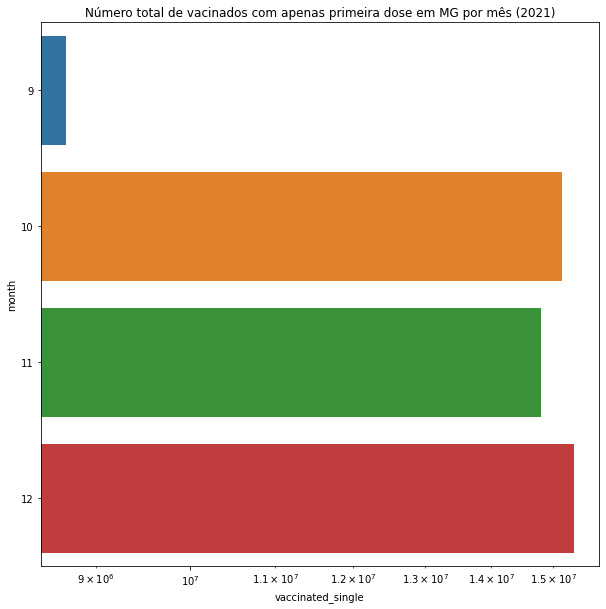

In [ ]:
mg_vaccinated('vaccinated_single','Número total de vacinados com apenas primeira dose em MG por mês (2021)')

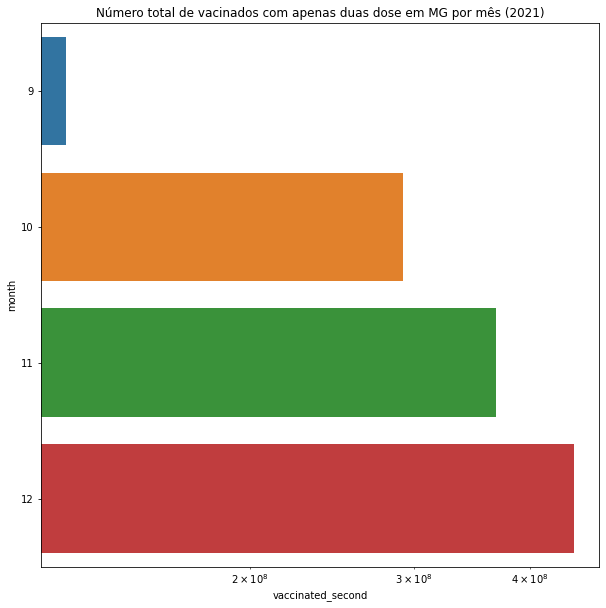

In [ ]:
mg_vaccinated('vaccinated_second','Número total de vacinados com apenas duas dose em MG por mês (2021)')

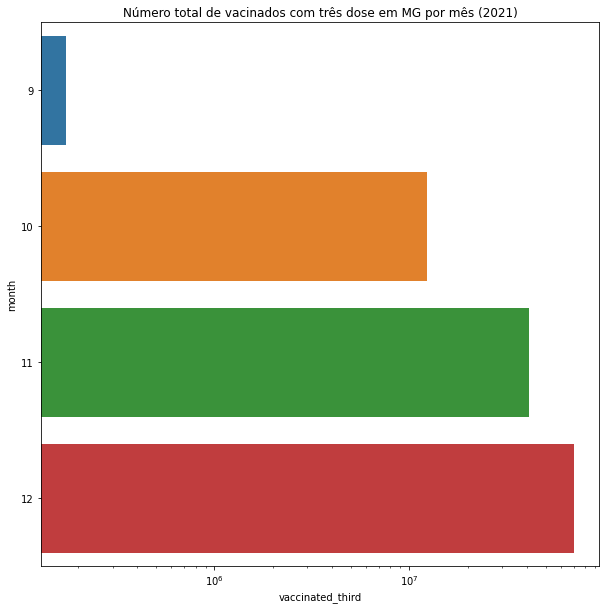

In [ ]:
mg_vaccinated('vaccinated_third','Número total de vacinados com três dose em MG por mês (2021)')

## Mapa de calor referente a vacinação

In [ ]:

display(data_without_nan_values.groupby('state')['vaccinated_per_100_inhabitants'].sum().sort_values())

state
AP       19172.65692
RR       20055.94818
AC       20866.51579
TO       21134.87568
MA       21216.18638
PA       21555.76777
RO       21749.42331
AM       21841.56601
AL       22113.63281
MT       22968.13160
BA       23512.17616
GO       23562.94851
RN       23913.38528
RJ       23935.12185
SE       24260.05461
DF       24544.14847
CE       24643.45726
MS       24880.31964
RS       25147.13144
PE       25199.75823
MG       25251.32268
PB       25299.11274
TOTAL    25549.65113
ES       25702.55399
SC       25748.10575
PR       25835.34429
PI       26050.48399
SP       28190.10302
Name: vaccinated_per_100_inhabitants, dtype: float64

### Vacinados por 100k de Habitantes

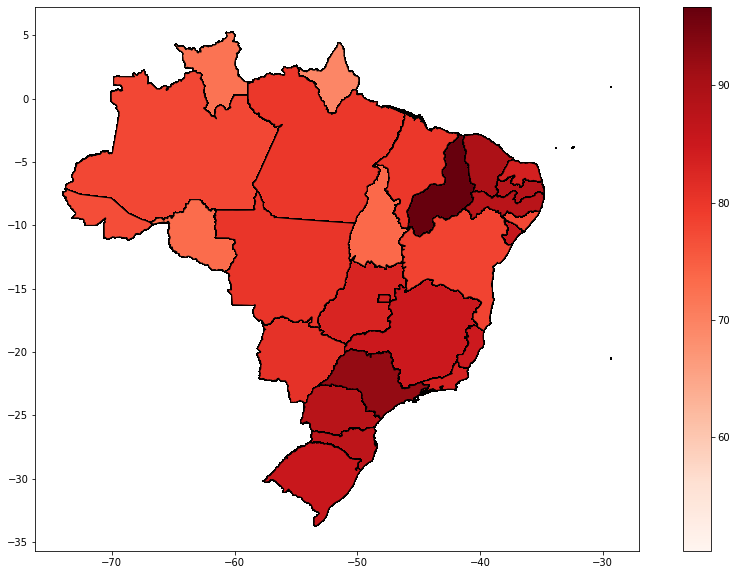

In [ ]:
INFOS_UFS = gpd.read_file('./bcim_2016_21_11_2018.gpkg', layer = 'lim_unidade_federacao_a')
INFOS_UFS.rename({'sigla':'state'}, axis = 1, inplace = True)

df_br = INFOS_UFS.merge(data_without_nan_values, on = 'state', how = 'left')

df_br.plot(column = 'vaccinated_per_100_inhabitants',
    cmap  = 'Reds',
    figsize = (16,10),
    legend = True,
    edgecolor = 'black',
    
    )

### Total de casos de Covid por 100k de Habitantes

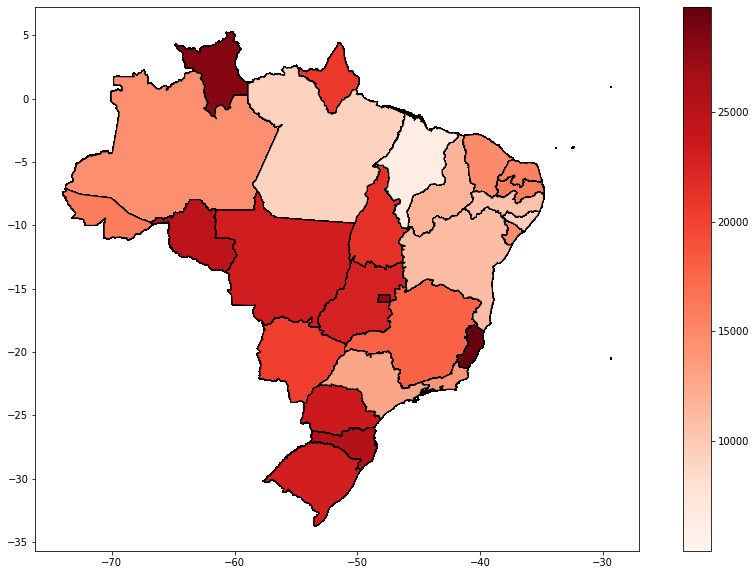

In [ ]:
df_br.plot(column = 'totalCases_per_100k_inhabitants',
    cmap  = 'Reds',
    figsize = (16,10),
    legend = True,
    edgecolor = 'black',
    )

# Regressão  


Análisando a tabela de correlações podemos manter ou retirar algumas colunas para realizar a regressão:

In [ ]:
cols_interesse = [
        'totalCases_per_100k_inhabitants', 'recovered', 'suspects',
       'tests_per_100k_inhabitants',
       'vaccinated_per_100_inhabitants', 
       'vaccinated_second_per_100_inhabitants', 
       'vaccinated_single_per_100_inhabitants', 
       'vaccinated_third_per_100_inhabitants']
target = 'state'

In [ ]:
cols_interesse_all = cols_interesse.copy()
#cols_interesse_all.append(target)  
data_for_pred = pd.read_csv('./cases-brazil-states.csv')

df = data_for_pred.dropna() 
df[cols_interesse_all]

,totalCases_per_100k_inhabitants,recovered,suspects,tests_per_100k_inhabitants,vaccinated_per_100_inhabitants,vaccinated_second_per_100_inhabitants,vaccinated_single_per_100_inhabitants,vaccinated_third_per_100_inhabitants
15089,13295.31707,354985.0,1381.0,37019.54598,66.07500,37.91534,8.45132,0.01015
15105,9767.02635,19138604.0,7958935.0,26706.17267,62.45918,28.24164,2.18512,0.00013
15117,13304.60103,357475.0,1381.0,37349.52245,66.17928,38.42790,8.45132,0.01342
15133,9778.09153,19243454.0,7958935.0,26765.35296,62.80953,28.79478,2.18888,0.00017
15145,13311.18617,357475.0,1381.0,37349.52245,66.37856,38.71804,8.45168,0.01932
...,...,...,...,...,...,...,...,...
24257,25560.61673,1607144.0,268966.0,35847.42493,87.06389,79.57998,3.87110,48.74370
24258,14781.24989,313577.0,445.0,26283.72782,85.85703,78.72120,1.82917,52.74821
24259,12813.00708,4850000.0,876238.0,42469.91918,92.34443,86.82408,2.77971,72.07291
24260,21428.14455,281464.0,359.0,57473.10960,73.56075,63.08166,3.49324,30.14987


## Correlações 
A correlação diz se dois atributos no dataset possuem alguma relação. 

In [ ]:
correlations = df.corr()
print(correlations)

                                       epi_week  newDeaths    deaths  \
epi_week                               1.000000  -0.045952 -0.004589   
newDeaths                             -0.045952   1.000000  0.714870   
deaths                                -0.004589   0.714870  1.000000   
newCases                               0.088873   0.744907  0.593018   
totalCases                             0.039599   0.687571  0.987691   
deathsMS                              -0.004582   0.714836  1.000000   
totalCasesMS                           0.039604   0.687447  0.987683   
deaths_per_100k_inhabitants            0.130763   0.056244  0.092232   
totalCases_per_100k_inhabitants        0.385895  -0.099934 -0.113023   
deaths_by_totalCases                  -0.370343   0.169475  0.207668   
recovered                              0.026300   0.685562  0.991224   
suspects                              -0.003056   0.639905  0.883567   
tests                                  0.000414   0.706677  0.99

In [ ]:
df.dtypes

epi_week                                   int64
date                                      object
country                                   object
state                                     object
city                                      object
newDeaths                                  int64
deaths                                     int64
newCases                                   int64
totalCases                                 int64
deathsMS                                   int64
totalCasesMS                               int64
deaths_per_100k_inhabitants              float64
totalCases_per_100k_inhabitants          float64
deaths_by_totalCases                     float64
recovered                                float64
suspects                                 float64
tests                                    float64
tests_per_100k_inhabitants               float64
vaccinated                               float64
vaccinated_per_100_inhabitants           float64
vaccinated_second   

In [ ]:
df['city'] = df["city"].astype('category')
df['city'] = df['city'].cat.codes 
df['country'] = df["country"].astype('category')  
df['country'] = df['country'].cat.codes 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df = pd.get_dummies(df, columns=["state"])

In [ ]:
df = df.drop(['date'], axis=1)

In [ ]:
df

,epi_week,date,country,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,...,state_RJ,state_RN,state_RO,state_RR,state_RS,state_SC,state_SE,state_SP,state_TO,state_TOTAL
15089,135,2021-09-02,0,0,11,9403,329,369475,9392,369146,...,0,0,0,0,0,0,0,0,0,0
15105,135,2021-09-02,0,0,782,582003,27021,20834790,581914,20830495,...,0,0,0,0,0,0,0,0,0,1
15117,135,2021-09-03,0,0,8,9411,258,369733,9403,369475,...,0,0,0,0,0,0,0,0,0,0
15133,135,2021-09-03,0,0,740,582743,23604,20858394,582670,20856060,...,0,0,0,0,0,0,0,0,0,1
15145,135,2021-09-04,0,0,7,9418,183,369916,9411,369733,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,230,2022-07-26,0,0,0,22186,0,1831364,22186,1831364,...,0,0,0,0,0,1,0,0,0,0
24258,230,2022-07-26,0,0,0,6406,0,339776,6406,339776,...,0,0,0,0,0,0,1,0,0,0
24259,230,2022-07-26,0,0,0,172555,0,5883611,172555,5883611,...,0,0,0,0,0,0,0,1,0,0
24260,230,2022-07-26,0,0,0,4182,0,337036,4182,337036,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
df.dtypes

epi_week                                   int64
country                                     int8
city                                        int8
newDeaths                                  int64
deaths                                     int64
newCases                                   int64
totalCases                                 int64
deathsMS                                   int64
totalCasesMS                               int64
deaths_per_100k_inhabitants              float64
totalCases_per_100k_inhabitants          float64
deaths_by_totalCases                     float64
recovered                                float64
suspects                                 float64
tests                                    float64
tests_per_100k_inhabitants               float64
vaccinated                               float64
vaccinated_per_100_inhabitants           float64
vaccinated_second                        float64
vaccinated_second_per_100_inhabitants    float64
vaccinated_single   

# Utilização de coeficiente de person para verificar relação entre variáveis

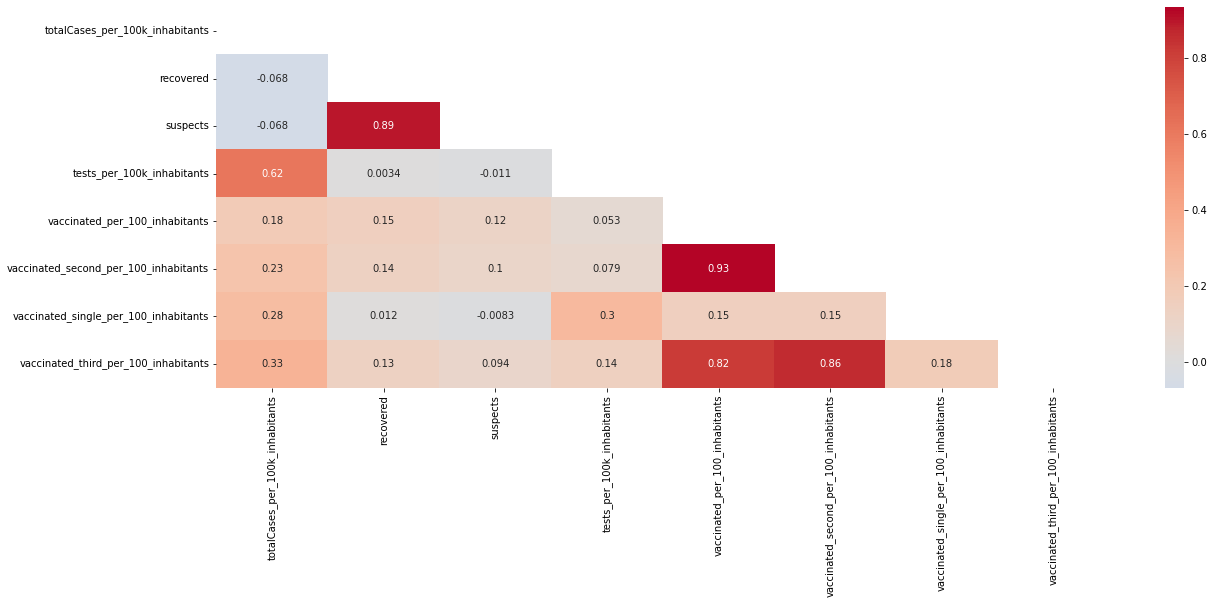

In [ ]:


Var_Corr = df[cols_interesse_all].corr()
matrix = np.triu(df[cols_interesse_all].corr())

plt.figure(figsize = (20,7))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns,\
            annot=True,center= 0, cmap= 'coolwarm',mask=matrix)

# Perguntas 

## 1) Qual região do país apresentou maior apatia ao programa de vacinação contra a COVID-19?

[247098.33883999998, 508256.07826999994, 208768.42608, 230064.24034000002, 227171.96730000002]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


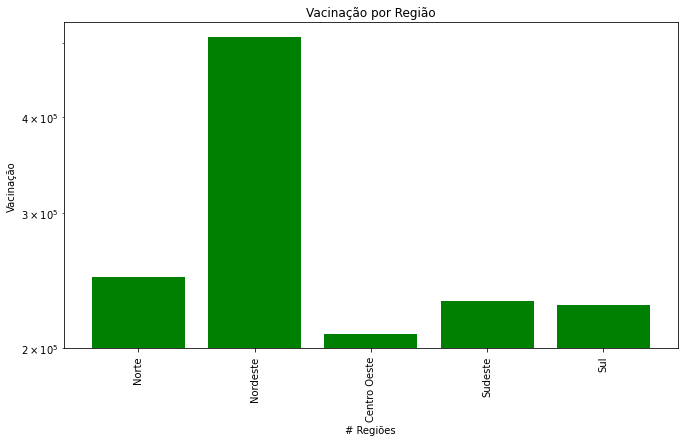

In [ ]:

sudeste = ['ES','MG','RJ','SP']  
nordeste = ['AL','BA','CE','MA','PA','PB','PE','PI','RN','SE']
centro_oeste = ['MT','MS','DF','GO']
norte = ['AM','AC','TO','AP','RO','RR']
sul = ['PR','RS','SC','PR']  


def sum_vac_by_region(region):
  
  sum = 0 
  for state in region:
    sum += df[df['state'] == state]['Total_vac_per_100'].sum()
    
  return sum


def list_of_differentes(regions):
  values = []
  for region in regions:
    values.append(sum_vac_by_region(region))

  return values  
 
cols = ['date', 'state',  'vaccinated_per_100_inhabitants',
       'vaccinated_second_per_100_inhabitants', 
       'vaccinated_single_per_100_inhabitants', 
       'vaccinated_third_per_100_inhabitants']  

data_1 = pd.read_csv('./cases-brazil-states.csv',usecols = cols, sep=',') 
df = data_1.dropna()  
df['Total_vac_per_100'] = df['vaccinated_per_100_inhabitants'] + df['vaccinated_second_per_100_inhabitants'] + df['vaccinated_single_per_100_inhabitants'] + df['vaccinated_third_per_100_inhabitants']

total_vac = df.groupby('state')['Total_vac_per_100'].sum()

values = list_of_differentes([norte,nordeste,centro_oeste,sudeste,sul])
regions = ['Norte','Nordeste','Centro Oeste','Sudeste','Sul'] 


print(values)

plt.figure(figsize =(11, 6))
plt.bar(regions, values, color = 'green')
plt.ylabel("Vacinação")
plt.xlabel("# Regiões")
plt.title("Vacinação por Região")
plt.xticks(rotation='vertical')
plt.yscale('log')
plt.show()


Analisando o gráfic juntamente com as informações coletadas nota-se que a região centro-oeste foi a que mais apresentou apatia à vacinação nos estados que a compõem. 

## 2) Qual região brasileira apresentou maior redução de mortes causadas por COVID-19 após o início das vacinações (Março/Abril 2021)?

In [ ]:
# Regiões

norte = ['AM', 'PA', 'RR', 'AP', 'RO', 'AC' , 'TO']
nordeste =  ['PI', 'MA', 'PE', 'RN', 'PB', 'CE', 'BA', 'AL','SE']
centro_oeste =  ['MT', 'MS','GO']
sudeste =  ['SP', 'RJ', 'ES', 'MG']
sul =  ['RS', 'PR', 'SC']

In [ ]:
start_vaccination = '2021-01-17'

data = data[data != 'TOTAL']

def difference_before_and_after_vaccinating(region):
  sum_before = 0
  sum_after = 0

  df_before = data[data['date']<start_vaccination]
  df_after = data[data['date']>=start_vaccination]

  for state in region:
    sum_before += df_before[df_before['state'] == state]['deaths'].sum()
    sum_after += df_after[df_after['state'] == state]['deaths'].sum()
  
  return sum_after - sum_before


def list_of_differentes(regions):
  values = []
  for region in regions:
    values.append(difference_before_and_after_vaccinating(region))

  return values  

values = list_of_differentes([norte,nordeste,centro_oeste,sudeste,sul])
regions = ['Norte','Nordeste','Centro Oeste','Sudeste','Sul']

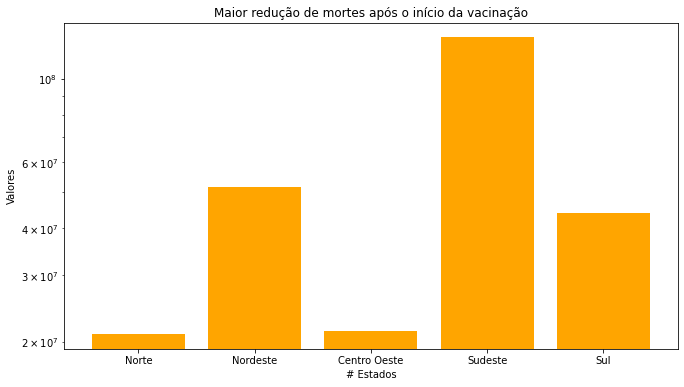

In [ ]:
plt.figure(figsize =(11, 6))
plt.bar(regions, values, color = 'orange')
plt.ylabel("Valores")
plt.xlabel("# Estados")
plt.title("Maior redução de mortes após o início da vacinação")
plt.yscale('log')
plt.show()

## 3) Qual região brasileira é mais afetada pela COVID-19?

In [ ]:
# Para se ter uma métrica justa utilizaremos o total de casos por 100l de habitantes
# totalCases_per_100k_inhabitants

def total_cases_by_region(region):
  sum = 0
  for state in region:
    sum +=  data_without_nan_values[data_without_nan_values['state'] == state]['totalCases_per_100k_inhabitants'].sum()

  return sum


def list_of_values(regions):
  values = []
  for region in regions:
    values.append(total_cases_by_region(region))

  return values

values = list_of_values([norte,nordeste,centro_oeste,sudeste,sul])
regions = ['Norte','Nordeste','Centro Oeste','Sudeste','Sul']

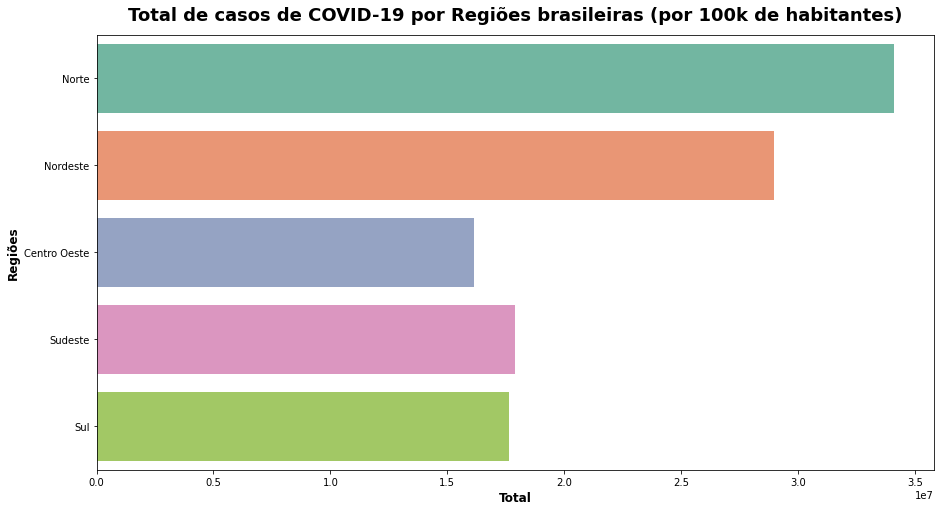

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x=values, y =regions , orient="h", palette="Set2")
plt.title('Total de casos de COVID-19 por Regiões brasileiras (por 100k de habitantes)',
          position=(0.5, 1.02),
          fontdict={'family': 'sans serif',
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 18})
plt.xlabel('Total', 
           fontdict={'family': 'sans serif',
                     'color' : 'black',
                     'weight': 'bold',
                     'size': 12})
plt.ylabel('Regiões', 
           fontdict={'family': 'sans serif',
                     'color' : 'black',
                     'weight': 'bold',
                     'size': 12})
plt.show()

Nota-se a partir do gráfico anterior que a região Norte é a mais afetada

## 4) Qual o avanço da COVID-19 no interior do Brasil?

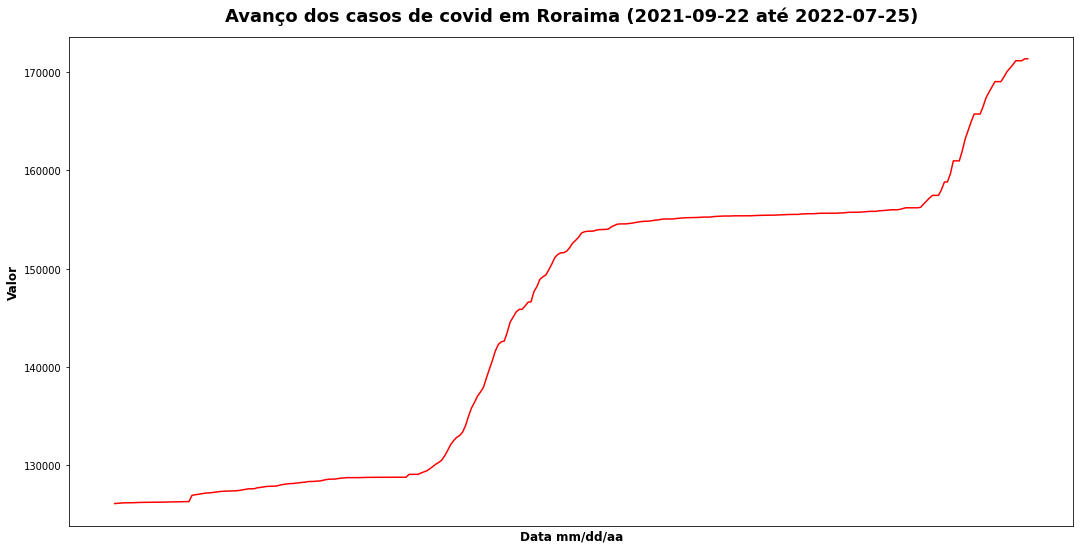

In [ ]:
## Roraima, Amapá e Acre

data_without_nan_values['date'].min()

def plot_graph(dataframe,color,title):
  plt.figure(figsize = (18,9))
  plt.ticklabel_format(style = 'plain')
  plt.xticks([])
  plt.title(title,
            position=(0.5, 1.02),
            fontdict={'family': 'sans serif',
                      'color' : 'black',
                      'weight': 'bold',
                      'size': 18})
  plt.xlabel('Data mm/dd/aa',
              fontdict={'family': 'sans serif',
                        'color' : 'black',
                        'weight': 'bold',
                        'size': 12})
  plt.ylabel('Valor',
              fontdict={'family': 'sans serif',
                        'color' : 'black',
                        'weight': 'bold',
                        'size': 12})
  plt.plot(dataframe['date'], dataframe['totalCases'], color = color)
  plt.show()


plot_graph(data_without_nan_values[data_without_nan_values['state'] == 'RR'],'red',"Avanço dos casos de covid em Roraima (2021-09-22 até 2022-07-25)")

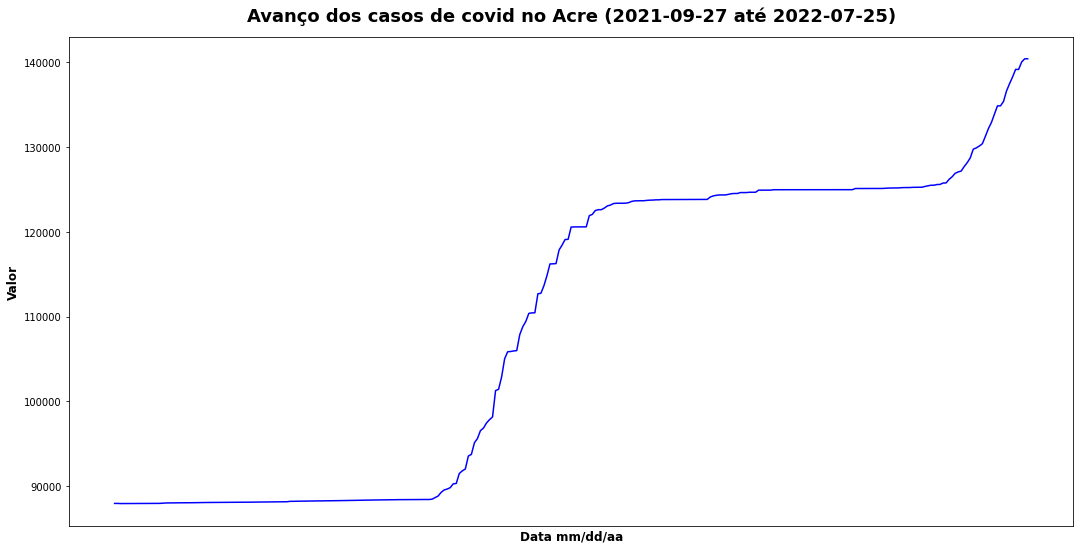

In [ ]:
plot_graph(data_without_nan_values[data_without_nan_values['state'] == 'AC'],'blue',"Avanço dos casos de covid no Acre (2021-09-27 até 2022-07-25)")

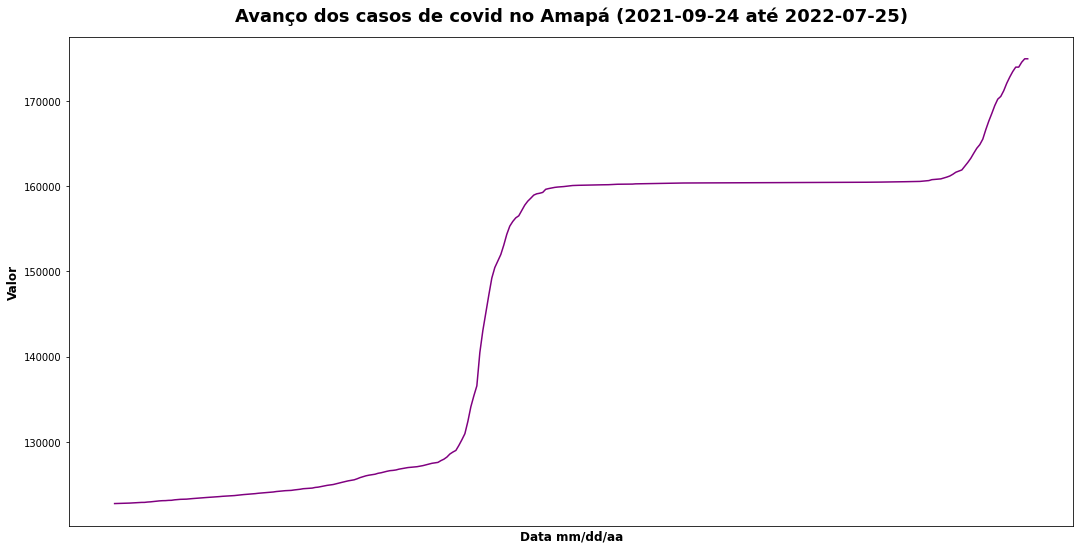

In [ ]:
plot_graph(data_without_nan_values[data_without_nan_values['state'] == 'AP'],'purple',"Avanço dos casos de covid no Amapá (2021-09-24 até 2022-07-25)")

## 5) Qual o aumento relativo de casos suspeitos de COVID-19 em 2022?

In [ ]:
beginning_of_2022 = data_without_nan_values[data_without_nan_values['date']<'2022-01-01']['suspects'].sum()
now = data_without_nan_values['suspects'].sum()

print(f'Teve um aumento relativo de: {now*100/beginning_of_2022}%')

Teve um aumento relativo de: 299.01389361673256%


## 6) Qual estado apresentou maior ocupação de leitos por COVID-19 desde o inicio da pandemia?

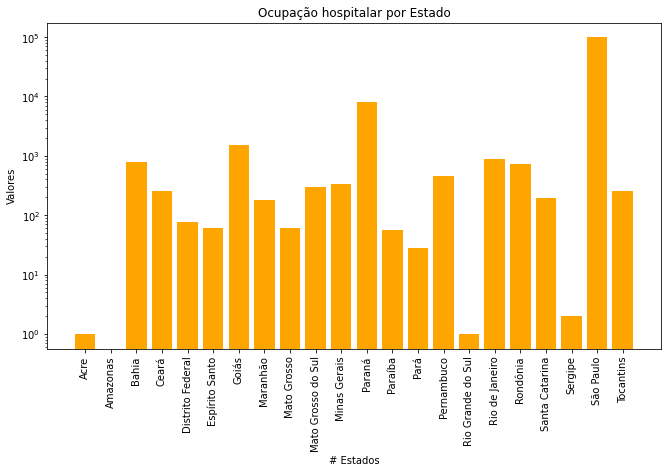

In [ ]:
def occupation_per_state(field,title):
    country_group_sum = newDfTotal.groupby('estadoNotificacao')[field].sum()

    plt.figure(figsize =(11, 6))
    plt.bar(country_group_sum.index, country_group_sum.values, color = 'orange')
    plt.ylabel("Valores")
    plt.xlabel("# Estados")
    plt.title(title)
    plt.xticks(rotation='vertical')
    plt.yscale('log')
    plt.show()

occupation_per_state('totalOcupacaoCovid',"Ocupação hospitalar por Estado")

# Ao analisar o gráfico com a relação do total de ocupação hospitalar devido a COVID-19, podemos inferir que o estado que mais apresentou ocupação durante os 3 anos de pandemia foi o estado de São Paulo. 

## 7) Qual ano houve a maior incidência de COVID-19 na região sudeste do Brasil?

In [ ]:
data = pd.read_csv('./cases-brazil-states.csv') 
data = data.dropna()
data['year'] = pd.DatetimeIndex(data['date']).year

In [ ]:
# Regiões

norte = ['AM', 'PA', 'RR', 'AP', 'RO', 'AC' , 'TO']
nordeste =  ['PI', 'MA', 'PE', 'RN', 'PB', 'CE', 'BA', 'AL','SE']
centro_oeste =  ['MT', 'MS','GO']
sudeste =  ['SP', 'RJ', 'ES', 'MG']
sul =  ['RS', 'PR', 'SC']


def incidence_southeast(region):
  sum = 0

  for state in region:
    sum += data[data['state'] == state]['totalCases'].sum()
  
  return sum


def list_(regions):
  values = []
  for region in regions:
    values.append(incidence_southeast(region))

  return values  

values = list_([norte,nordeste,centro_oeste,sudeste,sul])
regions = ['Norte','Nordeste','Centro Oeste','Sudeste','Sul']

In [ ]:
year_region = pd.DataFrame(list(zip(data['totalCases'], data['year'], regions)), columns = ['CasosTotais', 'Ano', 'Região'])
print(year_region)

   CasosTotais   Ano        Região
0       369475  2021         Norte
1     20834790  2021      Nordeste
2       369733  2021  Centro Oeste
3     20858394  2021       Sudeste
4       369916  2021           Sul


In [ ]:
year_region['Ano']

0    2021
1    2021
2    2021
3    2021
4    2021
Name: Ano, dtype: int64

In [ ]:
#Número total de casos de COVID por ano

data_groupby = data.groupby('year')['totalCases'].sum()
data_groupby

year
2021     4960492477
2022    12154140888
Name: totalCases, dtype: int64

## 8) Qual estado apresentou maior número de casos por 100 mil habitantes no ano de 2021?

In [ ]:
def get_by_year(df): 
  df["Date"] = pd.to_datetime(df["date"])
  df['Year'] = df['Date'].dt.year  
  df = df.drop('date', axis=1)
  return df[df['Year'] == 2021] 


cols = ['date', 'state',  
       'totalCases_per_100k_inhabitants']  

data = pd.read_csv('./cases-brazil-states.csv',usecols = cols, sep=',') 
df = data.dropna()      
cases = data.groupby('state')['totalCases_per_100k_inhabitants'].sum().sort_values()
only_21 = get_by_year(df)



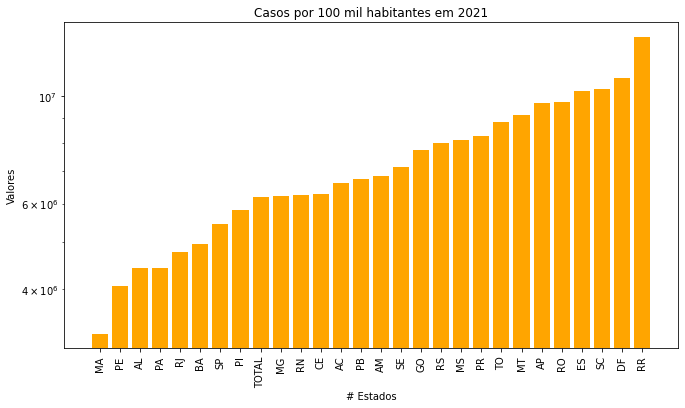

In [ ]:
plt.figure(figsize =(11, 6))
plt.bar(cases.index, cases.values, color = 'orange')
plt.ylabel("Valores")
plt.xlabel("# Estados")
plt.title("Casos por 100 mil habitantes em 2021")
plt.xticks(rotation='vertical')
plt.yscale('log')
plt.show()

## 9) Qual estado apresentou maior número de mortes por 100 mil habitantes no ano de 2021?


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


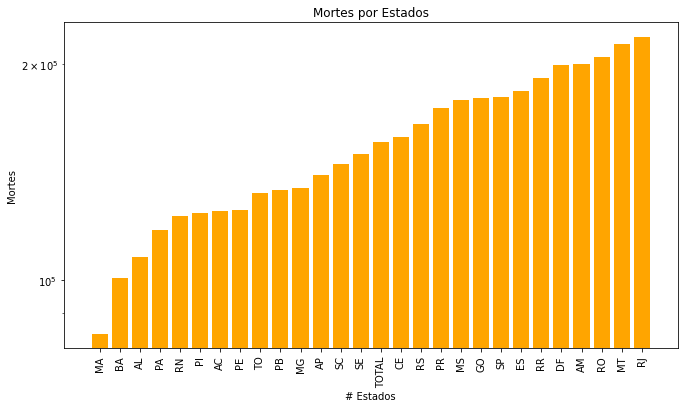

In [ ]:
def get_by_year(df): 
  df["Date"] = pd.to_datetime(df["date"])
  df['Year'] = df['Date'].dt.year  
  df = df.drop('date', axis=1)
  return df[df['Year'] == 2021] 


cols = ['date', 'state',  
       'deaths_per_100k_inhabitants','vaccinated_per_100_inhabitants','vaccinated_third_per_100_inhabitants', 'vaccinated_single_per_100_inhabitants', 'vaccinated_second_per_100_inhabitants']  

data = pd.read_csv('./cases-brazil-states.csv',usecols = cols, sep=',') 
df = data.dropna()      
deaths = data.groupby('state')['deaths_per_100k_inhabitants'].sum().sort_values()
only_21 = get_by_year(df)


plt.figure(figsize =(11, 6))
plt.bar(deaths.index, deaths.values, color = 'orange')
plt.ylabel("Mortes")
plt.xlabel("# Estados")
plt.title("Mortes por Estados")
plt.xticks(rotation='vertical')
plt.yscale('log')
plt.show()


#Percebe-se que o estado em que foi relatado um maior número de mortes por COVID-19 no ano de 2021 foi o Rio de Janeiro

## 10) Qual estado apresentou maior número de recuperados nos três anos de pandemia?


### Para identificar qual estado possuiu maior número de pacientes recuperados do COVID podemos realizar um groupby relacionando os estados e a coluna "recovered". Essa por sua vez, é responsável por guardar o número de casos recuperados, que é incrementado diáriamente.

### Como podemos observar abaixo, o estado de São Paulo possui mais de 4,8 milhões de recuperados de um total de aproximadamente 27,4 milhões em todo o país. Isso ocorre principalmente pelo tamanho da população de SP, bem como, a quantidade de contaminados.

In [ ]:
data_10 = pd.read_csv('./cases-brazil-states.csv', sep=',')
data_recovered = data_10.groupby('state')['recovered'].max().sort_values(ascending=False).head()
display(data_recovered)

state
TOTAL    27381416.0
SP        4850000.0
MG        3112513.0
RS        2146461.0
RJ        1948731.0
Name: recovered, dtype: float64

### Quando observamos o total de casos por 100.000 habitantes percebemos que São Paulo não está entre os estados mais preocupantes.


In [ ]:
data_100k = data_10.groupby('state')['totalCases_per_100k_inhabitants'].max().sort_values(ascending=False).head()
display(data_100k)

state
ES    29751.75743
RR    28288.38436
DF    27479.51426
SC    25560.61673
RO    24813.74052
Name: totalCases_per_100k_inhabitants, dtype: float64

### Esse valor representa cerca de 5.65 % do total de recuperados.

In [ ]:
(27381416/4850000)

5.645652783505154

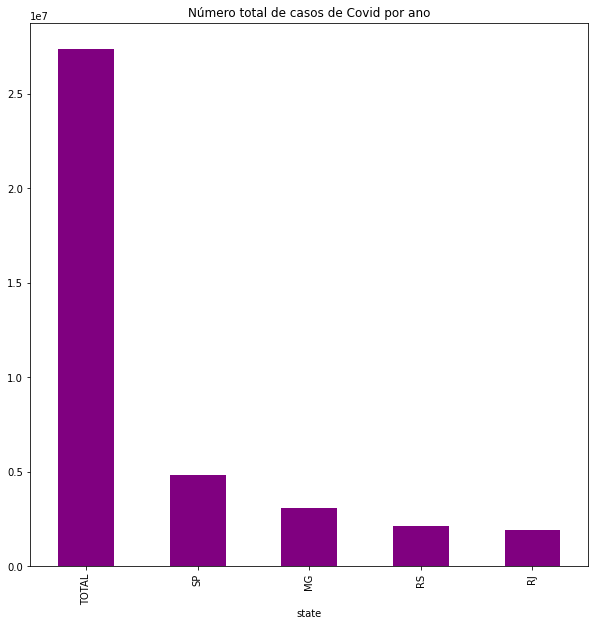

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Número total de casos de Covid por ano")
data_recovered.plot(kind='bar', x='state', y='recovered', color='purple', label = 'recovered')

## 11) Qual estado em teria maior simpatia por uma nova dose de vacina?


In [ ]:
df.columns

Index(['date', 'state', 'deaths_per_100k_inhabitants', 'Date', 'Year'], dtype='object')

In [ ]:
# create X and y
feature_cols = ['state_AC', 'state_AL','state_AM', 'state_AP', 'state_BA', 'state_CE', 'state_DF', 'state_ES',
       'state_GO', 'state_MA', 'state_MG', 'state_MS', 'state_MT', 'state_PA',
       'state_PB', 'state_PE', 'state_PI', 'state_PR', 'state_RJ', 'state_RN',
       'state_RO', 'state_RR', 'state_RS', 'state_SC', 'state_SE', 'state_SP',
       'state_TO']
X = df[feature_cols]
y = df.vaccinated_third_per_100_inhabitants

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print(lm.intercept_)
print(lm.coef_)

24.970540457317075
[-10.99545716  -6.40865528  -7.31444488 -15.30017928  -3.1524652
   3.10342545   1.55332009   0.86148232  -4.13161122 -10.70963594
   3.01967702   3.46682204  -8.97532331 -12.16182884   1.97680461
  -2.62544203   3.56829756   2.66626932   0.21515291   2.75744219
  -9.8822263  -15.8584625    4.62296961  -2.40918684  -0.07474468
  11.32803707 -10.44733786]


## Interpretando os coeficientes do modelo
- Para cada estado, é **associado** um aumento de V "unidade" nas vacinas de terceira dose aplicadas. 
- Considerando que todas as doses já foram aplicadas, uma única dose a mais seria considerada a quarta dose.  
- O estado que possui maior valor V é o estado de São Paulo com 11.32781948, o que indica que o mesmo teria maior simpatia na aplicação de uma nova dose de vacina em sua população. 

## 12) Há alguma relação entre estados e quantidade de doses aplicadas?


Para analisar se há alguma relação entre estados e quantidade de doses aplicadas, utilizamos o mapa de calor de correlações.
Juntamente com a tabela apresentada, podemos perceber que a correlação entre os estados e a quantidade de doses aplicadas é de 0.382931.




In [ ]:
data = pd.read_csv('./cases-brazil-states.csv') 
data = data.dropna()  

In [ ]:
correlation = data.corr()
correlation


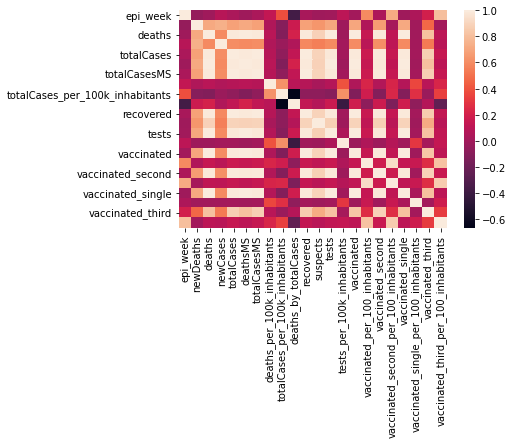

In [ ]:
sns.heatmap(data.corr())

## 13) Houve redução no número de casos de COVID-19 após 1 ano da aplicação da primeira dose da vacina contra COVID-19?


### Através do código abaixo podemos cobstatar que as primeiras doses registradas tratam-se do dia 17/01/2021.

In [ ]:
cols_13 = ['vaccinated','date','state','totalCases_per_100k_inhabitants']
data_13 = pd.read_csv('./cases-brazil-states.csv', usecols = cols_13, sep=',')
first_vaccination = data_13[(data_13['state'] == 'TOTAL')].dropna().sort_values(by=['date']).head(1)
first_vaccination

,date,state,totalCases_per_100k_inhabitants,vaccinated
8721,2021-01-17,TOTAL,3980.59581,112.0


### Após 1 ano, os seguintes dados foram coletados:

In [ ]:
first_vaccination_1_year = data_13[(data_13['state'] == 'TOTAL') & (data_13['date'] == '2022-01-17')].dropna().sort_values(by=['date']).head(1)
first_vaccination_1_year

,date,state,totalCases_per_100k_inhabitants,vaccinated
18941,2022-01-17,TOTAL,10824.53617,162370844.0


### Para responder essa pergunta, podemos tomar a porcentagem de contaminação comparada a quantidade de vacinados da seguinte maneira.

In [ ]:
def percent(total_cases, vaccinated):
  return (total_cases/vaccinated)*100

In [ ]:
case_1 = percent(112,3980)
print("Inicio: {:.2f} %".format(case_1))

Inicio: 2.81 %


In [ ]:
case_2 = percent(162370844,10824)
print("Fim: {:.2f} %".format(case_2))

Fim: 1500100.18 %


### Logo, percebemos que comparando o total de casos com o total de vacinados, ocorreu uma redução drástica do número de contaminados.

## 14) Houve redução no número de testes de COVID-19 após 1 ano da aplicação da primeira dose da vacina contra COVID-19?


### De maneira semelhante à questão anterior, é possível retirar as seguintes conclusões.


In [ ]:
cols_14 = ['vaccinated','date','state','totalCases_per_100k_inhabitants','tests_per_100k_inhabitants']
data_14 = pd.read_csv('./cases-brazil-states.csv', usecols = cols_13, sep=',')
first_vaccination = data_13[(data_13['state'] == 'TOTAL')].dropna().sort_values(by=['date']).head(1)
first_vaccination

,date,state,totalCases_per_100k_inhabitants,vaccinated
8721,2021-01-17,TOTAL,3980.59581,112.0


In [ ]:
first_vaccination_1_year = data_13[(data_13['state'] == 'TOTAL') & (data_13['date'] == '2022-01-17')].dropna().sort_values(by=['date']).head(1)
first_vaccination_1_year

,date,state,totalCases_per_100k_inhabitants,vaccinated
18941,2022-01-17,TOTAL,10824.53617,162370844.0


### Dessa forma, é perceptivel que houve um aumento percentual na quantidade de testes realizados.

## 15) Qual estado realizou a maior testagem nos três anos?


### Baseando-se nos dados disponibilizados pelo dataset, podemos observar uma coluna que trata de quantidade de teste realizados por 100.000 habitantes. Dessa forma, agrupando esses dados por estado, é perceptível que Roraima está presente no primeiro lugar.

In [ ]:
cols_15 = ['state','tests_per_100k_inhabitants']
data_15 = pd.read_csv('./cases-brazil-states.csv', usecols = cols_15, sep=',')
data_15.groupby('state').max().sort_values(by=['tests_per_100k_inhabitants'], axis=0, ascending=False).head()

,tests_per_100k_inhabitants
state,
RS,68117.36134
RR,66655.66123
RO,62512.00608
ES,59629.30337
TO,57473.10960


## 16) Qual estado aplicou mais vacinas até o momento?

In [ ]:
data = pd.read_csv('./cases-brazil-states.csv') 
data = data.dropna()    
data = data[data.state != 'TOTAL']

In [ ]:
#Agrupando por estado e número de vacinados
state_vaccinated = data.groupby('state')['vaccinated'].max()

In [ ]:
#state_vaccinated = state_vaccinated[state_vaccinated != 'TOTAL']
state_vaccinated

state
AC      679357.0
AL     2596051.0
AM     3218123.0
AP      586273.0
BA    11643750.0
CE     8167779.0
DF     2531533.0
ES     3411026.0
GO     5818458.0
MA     5655223.0
MG    17989682.0
MS     2246878.0
MT     2797407.0
PA     6869359.0
PB     3547278.0
PE     8372198.0
PI     3163444.0
PR    10054087.0
RJ    14385362.0
RN     2933984.0
RO     1302438.0
RR      436913.0
RS     9722787.0
SC     6237943.0
SE     1973592.0
SP    42403685.0
TO     1157012.0
Name: vaccinated, dtype: float64

Analisando os dados apresentados, é possível observar que o estado que aplicou mais vacinas até o momento foi São Paulo, com um total de 42396507 vacinas aplicadas.

In [ ]:
print('Estado:', state_vaccinated.idxmax())
print('Número total de vacinas: ', state_vaccinated.max())

Estado: SP
Número total de vacinas:  42403685.0


## 17)   Qual estado apresentou maior sobrecarga do sistema por suspeita de COVID-19 desde o inicio da pandemia?

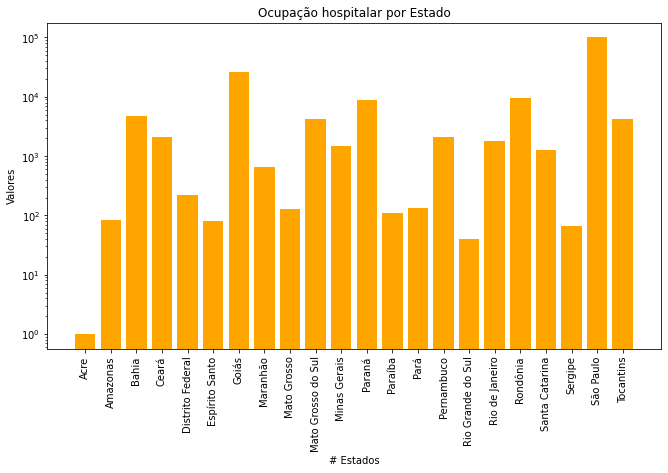

In [ ]:
def occupation_per_state(field,title):
    country_group_sum = newDfTotal.groupby('estadoNotificacao')[field].sum()

    plt.figure(figsize =(11, 6))
    plt.bar(country_group_sum.index, country_group_sum.values, color = 'orange')
    plt.ylabel("Valores")
    plt.xlabel("# Estados")
    plt.title(title)
    plt.xticks(rotation='vertical')
    plt.yscale('log')
    plt.show()

occupation_per_state('totalOcupacaoHospitalar',"Ocupação hospitalar por Estado")

# Ao analisar o gráfico com a relação do total de ocupação hospitalar devido independente de doença, no periodo da pandemia, podemos inferir que o estado que mais apresentou ocupação durante os 3 anos de pandemia foi o estado de São Paulo. 

## 18) Utilize o KNN como técnica de aprendizado de máquina supervisionado para prever o total de casos de COVID-19 por 100k de habitantes

In [ ]:
from sklearn import metrics

In [ ]:
data['totalCases_per_100k_inhabitants_test'] = data['totalCases_per_100k_inhabitants'].apply(lambda x: 1 if x > data['totalCases_per_100k_inhabitants'].mean() else 0)
data['vaccinated_per_100_inhabitants_test'] = data['vaccinated_per_100_inhabitants'].apply(lambda x: 1 if x > data['vaccinated_per_100_inhabitants'].mean() else 0)

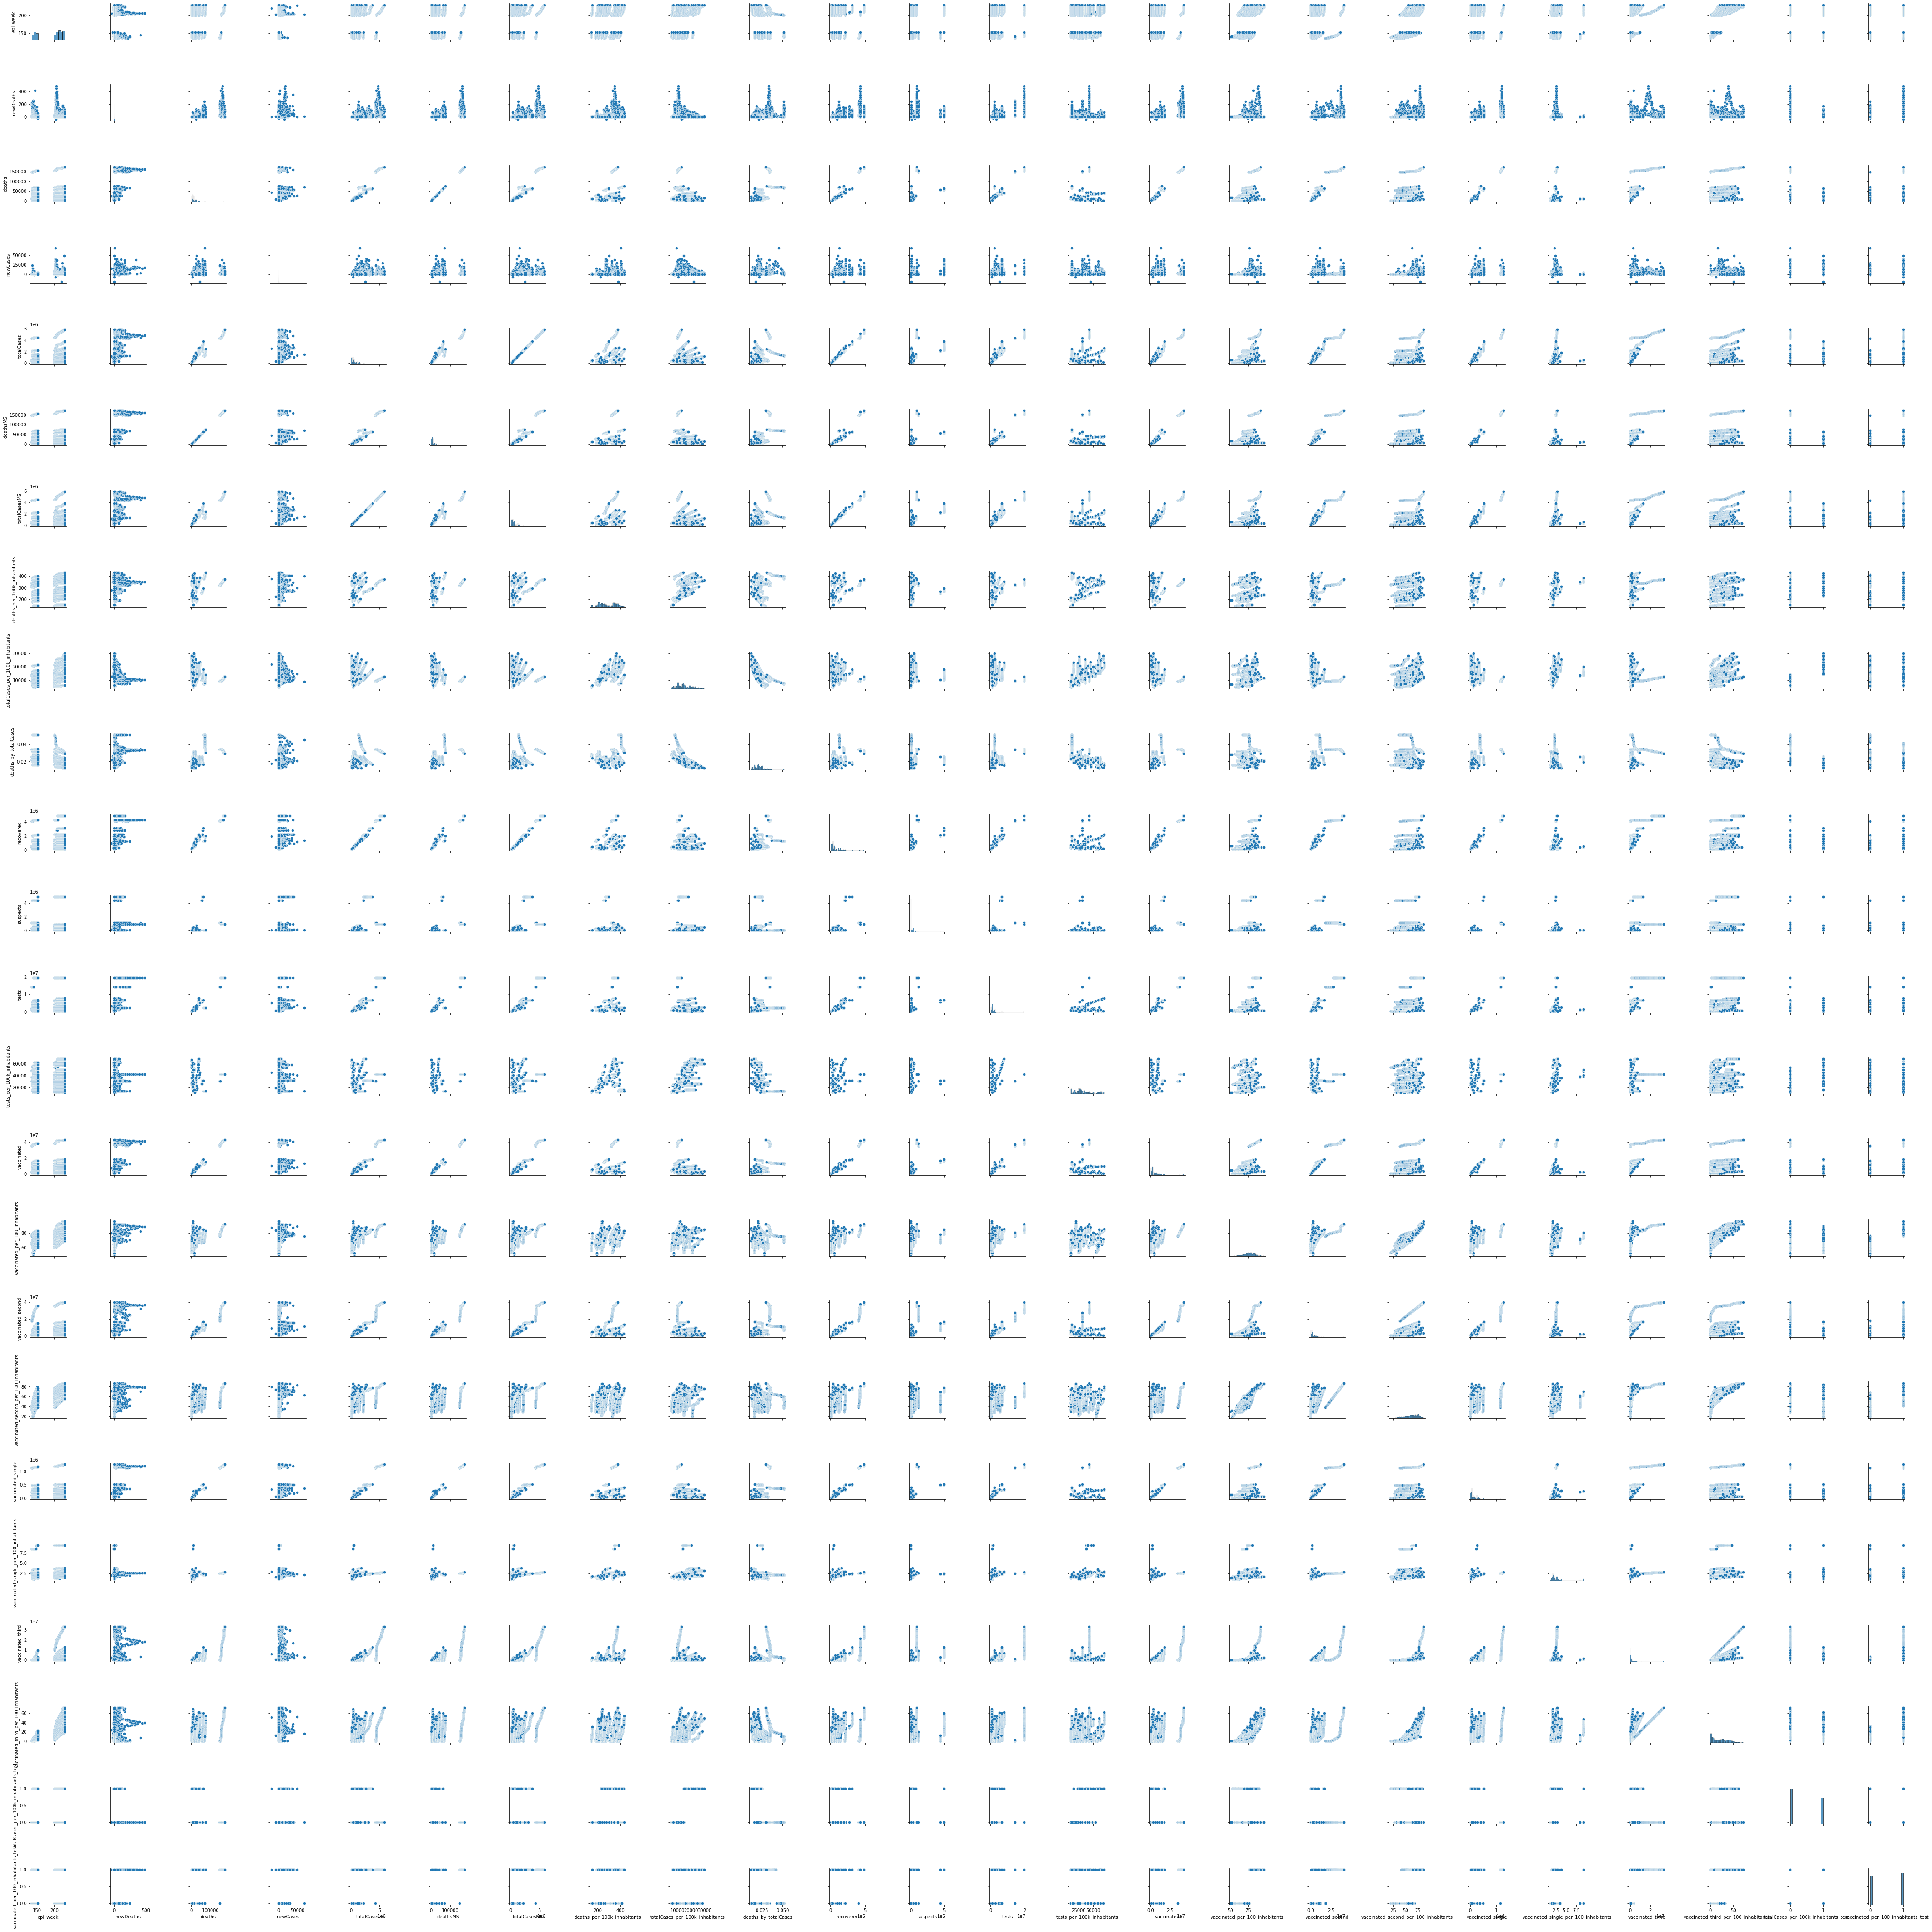

In [ ]:
sns.pairplot(data)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


def classifier(X_train,X_test,Y_train,Y_test):
    #Aplicando KNN
    print(" KNN ")
    ini = time.time() #Inicio do calculo do tempo

    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    end = time.time()
    knn_time = end - ini # Fim do calculo do tempo

    knn_Y_predicted = knn.predict(X_test)
    knn_accuracy = np.sum(knn_Y_predicted == Y_test) / len(Y_test)

    print(classification_report(Y_test,knn.predict(X_test)))
    print(confusion_matrix(Y_test, knn.predict(X_test)))
    print(f"Tempo gasto: {knn_time}")

    cm = metrics.confusion_matrix(Y_test, knn_Y_predicted, labels=knn.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
    disp.plot()
    plt.show()
    

Y = data['totalCases_per_100k_inhabitants_test']

 KNN 
              precision    recall  f1-score   support

           0       0.57      1.00      0.72       951
           1       0.00      0.00      0.00       722

    accuracy                           0.57      1673
   macro avg       0.28      0.50      0.36      1673
weighted avg       0.32      0.57      0.41      1673



/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

[[951   0]
 [722   0]]
Tempo gasto: 0.004788875579833984


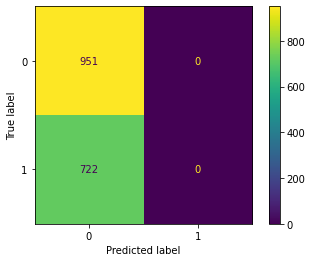

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(data['vaccinated_per_100_inhabitants_test'].values.reshape(-1,1),Y.values.reshape(-1,1),test_size=0.2, random_state=0)
classifier(X_train,X_test,Y_train,Y_test)

## 19) De maneira análoga à questão anterior, podemos prever o total de casos de covid por 100k habitantes utilizando outras técnicas de aprendizado supervisionado?

### Podemos tratar os dados acima utilizando a árvore de decisões também. Da seguinte forma:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
import time
import matplotlib.pyplot as plt

In [ ]:
def classifierDecisionTree(X_train,X_test,Y_train,Y_test):
    #Aplicando Arvore de decisões
    print(" Árvore de decisões ")
    ini = time.time() #Inicio do calculo do tempo

    decisionTree = DecisionTreeClassifier(random_state=0)
    decisionTree.fit(X_train,Y_train)

    end = time.time()
    decisionTree_time = end - ini # Fim do calculo do tempo

    decisionTree_Y_predicted = decisionTree.predict(X_test)
    decisionTree_accuracy = np.sum(decisionTree_Y_predicted == Y_test) / len(Y_test)

    print(classification_report(Y_test,decisionTree.predict(X_test)))
    print(confusion_matrix(Y_test, decisionTree.predict(X_test)))
    print(f"Tempo gasto: {decisionTree_time}")
    cm = metrics.confusion_matrix(Y_test, decisionTree_Y_predicted, labels=decisionTree.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decisionTree.classes_)
    disp.plot()
    plt.show()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8364 entries, 15089 to 24260
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   epi_week                               8364 non-null   int64  
 1   date                                   8364 non-null   object 
 2   country                                8364 non-null   object 
 3   state                                  8364 non-null   object 
 4   city                                   8364 non-null   object 
 5   newDeaths                              8364 non-null   int64  
 6   deaths                                 8364 non-null   int64  
 7   newCases                               8364 non-null   int64  
 8   totalCases                             8364 non-null   int64  
 9   deathsMS                               8364 non-null   int64  
 10  totalCasesMS                           8364 non-null   int64  
 11 

In [ ]:
# # data.dropna(inplace=True)

# X_train, X_test, Y_train, Y_test = train_test_split(
#     data[['deaths','recovered']].values,
#     data["vaccinated_per_100_inhabitants"].astype(int).values.reshape(-1,1),
#     test_size=0.2,
#     random_state=0
# )

 Árvore de decisões 
              precision    recall  f1-score   support

           0       0.57      1.00      0.72       951
           1       0.00      0.00      0.00       722

    accuracy                           0.57      1673
   macro avg       0.28      0.50      0.36      1673
weighted avg       0.32      0.57      0.41      1673

[[951   0]
 [722   0]]
Tempo gasto: 0.0023682117462158203


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


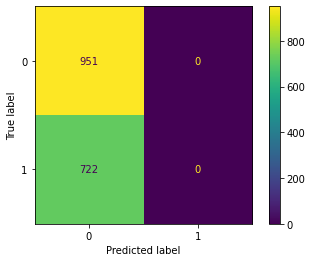

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(data['vaccinated_per_100_inhabitants_test'].values.reshape(-1,1),Y.values.reshape(-1,1) ,test_size=0.2, random_state=0)
classifierDecisionTree(X_train,X_test,Y_train,Y_test)

# 20)A partir do número de pessoas vacinadas, é possível prever a quantidade de pessoas que se recuperam?

Primeiro fazemos a leitura do dataset e retiramos os valores nulos.

In [ ]:
data = pd.read_csv('./cases-brazil-states.csv') 
data = data.dropna()

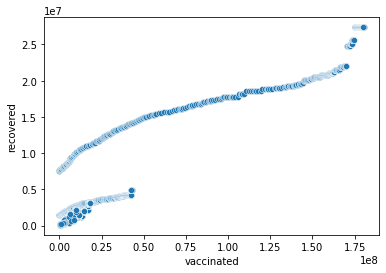

In [ ]:
sns.scatterplot(data=data, x="vaccinated", y="recovered")

Iremos criar um modelo de Regressão linear utilizando 'vaccinated' e 'recovered'.

Variável Independente: vaccinated 

Variável Dependente: recovered

In [ ]:
X = data.vaccinated
Y = data.recovered

lm = LinearRegression()
lm.fit(X.values.reshape(-1,1), Y)

print('Coeficiente estimado: ', lm.coef_)
print('R2 (score): ', lm.score(X.values.reshape(-1,1), Y))

Coeficiente estimado:  [0.14500215]
R2 (score):  0.9359797226771155


Ou seja, a cada aumento de 1 pessoa a mais vacinada, o número de pessoas recuperadas aumenta 0.14. O R2 (coeficiente de determinação) é de 0.93. Ou seja, 93% da variação de pessoas recuperadas não é explicada pelo número de pessoas vacinadas.

Agora vamos fazer a regressão multi-variada. Para isso, vamos separar os atributos independentes (X) e o atributo dependente recovered (Y), e criar uma instância da classe LinearRegression

Variável Independente: Todas colunas, exceto recovered
Variável Dependente: recovered

Antes de começarmos a regressão multi-variada, é necessário tratar as variáveis categóricas.

In [ ]:
data = data.drop('date', axis=1)
data['city'] = data["city"].astype('category')
data['city'] = data['city'].cat.codes 
data['country'] = data["country"].astype('category')  
data['country'] = data['country'].cat.codes 
data = pd.get_dummies(data, columns=["state"])

In [ ]:
data

,epi_week,country,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,...,state_RJ,state_RN,state_RO,state_RR,state_RS,state_SC,state_SE,state_SP,state_TO,state_TOTAL
8719,103,0,0,60,49945,5720,1625339,49945,1625339,108.76750,...,0,0,0,0,0,0,0,1,0,0
8721,103,0,0,551,209921,31414,8491313,209847,8488099,98.40771,...,0,0,0,0,0,0,0,0,0,1
8747,103,0,0,42,49987,2933,1628272,49987,1628272,108.85896,...,0,0,0,0,0,0,0,1,0,0
8749,103,0,0,476,210397,28924,8520237,210299,8511770,98.63085,...,0,0,0,0,0,0,0,0,0,1
8775,103,0,0,331,50318,15953,1644225,50318,1644225,109.57980,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,230,0,0,0,22186,0,1831364,22186,1831364,309.65327,...,0,0,0,0,0,1,0,0,0,0
24258,230,0,0,0,6406,0,339776,6406,339776,278.67974,...,0,0,0,0,0,0,1,0,0,0
24259,230,0,0,0,172555,0,5883611,172555,5883611,375.78087,...,0,0,0,0,0,0,0,1,0,0
24260,230,0,0,0,4182,0,337036,4182,337036,265.88406,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
X = data.drop('recovered', axis=1)
Y = data.recovered

lm = LinearRegression()
lm.fit(X, Y)

print('Coeficiente estimado: ', lm.coef_)
print('R2 (score): ', lm.score(X, Y))

Coeficiente estimado:  [ 5.86987119e+02 -3.20427863e-01  2.37423290e+00  1.63289416e+02
 -1.71729373e+02 -9.47069574e+00 -4.24105916e+00  1.66219268e+02
  4.85267252e+00  1.66604848e+03 -4.66644458e+00 -4.83897679e+06
  4.01113797e-01  5.76043334e-02 -4.93694683e+00  2.56606712e-02
 -6.45668569e+02  4.10316304e-04 -1.73497233e+03 -1.70578281e-01
  4.38317435e+04  4.82625800e-05 -1.03729273e+03  5.43123426e+04
  7.85114006e+04 -6.43471034e+03 -3.76133923e+04  1.87262968e+05
  9.93553401e+04 -3.78621863e+03 -3.45097532e+04 -1.77186392e+05
  9.84037645e+04 -1.44650394e+06 -2.55549458e+05 -1.28665511e+05
  1.16341766e+05 -1.49076499e+05  2.45902345e+04  1.00843393e+05
  1.17097640e+05  2.35488649e+05 -4.09251032e+04 -1.71569254e+05
  1.51538445e+04  2.88883520e+05  1.85022802e+05  4.58884141e+04
  4.74585394e+04  8.30348052e+04  6.74170803e+05]
R2 (score):  0.9993371360341853


É possível observar como o R2 melhorou ao adicionar as outras variáveis.

Agora, vamos apresentar os coeficientes estimados para todas as variáveis independentes.

In [ ]:
# Mostrar os coeficientes da regressão.
print('Intercept %.3f ' % lm.intercept_)

Intercept -136421.991 


In [ ]:
coeff_data = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])
coeff_data

,Coefficient
epi_week,5.869871e+02
country,-3.204279e-01
city,2.374233e+00
newDeaths,1.632894e+02
deaths,-1.717294e+02
newCases,-9.470696e+00
totalCases,-4.241059e+00
deathsMS,1.662193e+02
totalCasesMS,4.852673e+00
deaths_per_100k_inhabitants,1.666048e+03


A partir dos vacinados, vamos tentar prever os recuperados.

In [ ]:
X = sm.add_constant(data.drop('recovered', axis =1))
Y = data.recovered

results = sm.OLS(Y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              recovered   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.859e+05
Date:                Wed, 27 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:21:23   Log-Likelihood:            -1.2030e+05
No. Observations:                9152   AIC:                         2.407e+05
Df Residuals:                    9103   BIC:                         2.410e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Podemos ver que vaccinated_second, vaccinated_third, state_DF e state_RR apresentaram um valor-p alto, e o intervalo de confiança inclui zero. Então podemos remover essa variáveis e vamos ver que o resultado não muda significativamente.

In [ ]:
X = sm.add_constant(data.drop(['recovered', 'vaccinated_second', 'vaccinated_third', 'state_DF', 'state_RR'], axis=1))
Y = data.recovered

results = sm.OLS(Y,X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              recovered   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.050e+05
Date:                Wed, 27 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:28:20   Log-Likelihood:            -1.2030e+05
No. Observations:                9152   AIC:                         2.407e+05
Df Residuals:                    9106   BIC:                         2.410e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Notamos que R2 continuou igual!

Logo, não podemos dizer que a partir do número de pessoas vacinadas é possível prever o número de recuperadas. 

O valor do nosso R2 ao final da regressão foi de 0.99, o que indica que apenas 1% da variação de pessoas recuperadas não pode ser explicada pelas outras variáveis. 